In [167]:
from itertools import product
import torch
import tqdm
import math
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils import variance_norms, isometry_gap, dataset_configs


# Define the MLP model with layer normalization
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes, activation, normalization, **kwargs):
        super(MLP, self).__init__()
        if normalization == 'LN':
            self.norm = nn.LayerNorm
        elif normalization == 'BN':
            self.norm = nn.BatchNorm1d
        elif normalization == 'None':
            self.norm = nn.Identity
        if not isinstance(input_size, int):
            p = 1
            for s in input_size:
                p *= s
            input_size = p

        self.layers = nn.Sequential()
        hidden_sizes = [input_size] + hidden_sizes + [num_classes]
        num_layers = len(hidden_sizes)
        # self.layers.add_module('fc-0', nn.Linear(input_size, hidden_size))
        # self.layers.add_module('norm-0', self.norm(hidden_size))

        for i, (h1,h2) in enumerate(zip(hidden_sizes[:-1],hidden_sizes[1:])):
            self.layers.add_module(f'norm-{i}', self.norm((h1)))
            self.layers.add_module(f'fc-{i}', nn.Linear(h1, h2))
            self.layers.add_module(f'act-{i}', getattr(nn, activation)())

        # self.layers.add_module(f'fc-{num_layers - 1}', nn.Linear(hidden_size, num_classes))
        self.apply(self.init_weights)

    def init_weights(self, layer):
        if isinstance(layer, nn.Linear):
            std = 1 / math.sqrt(layer.weight.size(1))
            nn.init.normal_(layer.weight, mean=0, std=std)

    def forward(self, x):
        x = x.view(x.size(0), -1)        
        hidden_layers = []
        for i, (name, layer) in enumerate(self.layers.named_children()):
            hidden_layers.append((name, x, layer(x)))
            x = layer(x)
        output = x
        return output, hidden_layers


def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs, hidden = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return loss


def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs, hidden = model(images)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

# h must be n x d, where d >= n
def isometry_gap(h, epsilon = 0, reduce_mean = False):
    if reduce_mean:
        h = h - h.mean(dim=1,keepdim=True)
    G = h @ h.t()
    vals = torch.linalg.eigvalsh(G) + epsilon
    log_vals = torch.log(vals)
    mean_log_vals = torch.mean(log_vals)
    log_mean_vals = torch.log(torch.mean(vals))
    iso_gap = log_mean_vals - mean_log_vals
    return iso_gap

def variance_norms(tensor,reduce_mean=False, dim=0):
    if reduce_mean:
        tensor = tensor - tensor.mean(dim=dim,keepdim=True)
    row_norms = torch.norm(tensor, dim=dim)  # Compute the norms of each row
    mean_norm = torch.mean(row_norms)  # Compute the mean norm
    var_norm = torch.var(row_norms)  # Compute the variance of norms
    return var_norm / mean_norm**2

def run_experiment(config):
    def record_results(model, loader, df, stage, num_batches = 5, reduce_mean = False):
        # Record results
        for i, (images, labels) in enumerate(loader):
            if i > num_batches:
                break
            images = images.to(device)
            labels = labels.to(device)

            outputs, hidden = model(images)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            for li, (l, h0, h) in enumerate(hidden):
                h = h.flatten(1)
                ig = isometry_gap(h, reduce_mean=reduce_mean, epsilon=1e-8).item()
                nb = variance_norms(h0, reduce_mean=True, ).item()
                df.append({**config,
                    'l': li,
                    'layer': l,
                    'iso_gap': ig,
                    'norm_bias': nb,
                    'stage': stage,
                    'loss': loss.item(),
                    'accuracy': (predicted == labels).sum().item() / len(labels),
                    'epoch': epoch,
                    'i': i
                })

    # Data preprocessing
    ds_config = dataset_configs[config['dataset']]
    transform = ds_config['transform']
    config['input_size'] = ds_config['input_size']
    config['num_classes'] = ds_config['num_classes']

    train_dataset = getattr(datasets, config['dataset'])(root='./data', train=True, transform=transform, download=True)
    test_dataset = getattr(datasets, config['dataset'])(root='./data', train=False, transform=transform, download=True)

    train_loader = DataLoader(dataset=train_dataset, batch_size=config['batch_size'], shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=config['batch_size'], shuffle=False)

    # Create the model, loss function, and optimizer
    device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

    df = []
    model = MLP(**config).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=config['learning_rate'])

    for epoch in tqdm.trange(config['num_epochs']):
        if epoch > 0:
            loss = train_model(model, train_loader, criterion, optimizer, device)
            print(f'Epoch [{epoch + 1}/{config["num_epochs"]}], Train Loss: {loss.item():.4f}')
        record_results(model, train_loader, df, 'train', reduce_mean=config['reduce_mean'])

        # Evaluate the model on test data
        accuracy = evaluate_model(model, test_loader, criterion, device)
        print(f'Test Accuracy of the model on the 10000 test images: {100 * accuracy:.2f}%')
        record_results(model, test_loader, df, 'test', reduce_mean=config['reduce_mean'])

    df = pd.DataFrame(df)
    return df


def generate_configs(config_grid):
    config_list = list(product(*config_grid.values()))
    config_dicts = []
    for config_tuple in config_list:
        config_dict = dict(zip(config_grid.keys(), config_tuple))
        config_dicts.append(config_dict)
    return config_dicts



def compute_beta(act):
    x = torch.randn(1000000)
    c0 = act(x).mean()
    c1 = (act(x)*x).mean()
    csum2 = (act(x)**2).mean()
    beta0 = 2 - c1**2 / (csum2 - c0**2)
    # c0, c1, csum2, beta0
    return beta0.item()

def run_experiment_grid(config_grid):
    # Generate all possible configurations from the config grid
    config_list = generate_configs(config_grid)

    # Run the experiments for each config
    all_results_df = []
    for config in config_list:
        print(f"Running experiment for config: {config}")
        results_df = run_experiment(config)
        all_results_df.append(results_df)

    # Concatenate the results of all experiments into a single DataFrame
    final_results_df = pd.concat(all_results_df, ignore_index=True)
    final_results_df['beta'] = 0
    for act in final_results_df.activation.unique():
        F = getattr(nn, act)()
        beta = compute_beta(F)
        final_results_df.loc[final_results_df.activation==act, 'beta'] = beta
    final_results_df['mlp_shape'] = final_results_df.apply(lambda x: str(x.hidden_sizes), axis=1)
    return final_results_df

def gen_config_grid(**kwargs):
    # Define the default config grid with lists of possible values for each parameter
    config_grid = {
        'model': ['MLP'],
        'dataset': ['CIFAR10','CIFAR100'],
        'hidden_sizes': [[1000]*10],
        'batch_size': [512],
        'learning_rate': [0.01,],
        'num_epochs': [10],
        'reduce_mean': [False],
        'rerun': range(1),
        'activation': ["ReLU", "Identity","PReLU", "Tanh","SELU","SiLU", "ELU", "GELU"],
        'normalization': ["LN",],
    }
    for k,v in kwargs.items():
        assert( k in config_grid )
        config_grid[k] = v
    return config_grid

sns.set_theme(style="white")
sns.set_style('ticks')


Running experiment for config: {'model': 'MLP', 'dataset': 'MNIST', 'hidden_sizes': [1000, 1000, 1000, 1000, 1000], 'conv_channels': [32, 64, 128, 256], 'fc_layers': [512], 'batch_size': 100, 'learning_rate': 0.01, 'num_epochs': 1, 'rerun': 0, 'reduce_mean': False, 'activation': 'ReLU', 'normalization': 'LN'}


  0%|          | 0/1 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 10.31%


100%|██████████| 1/1 [00:02<00:00,  2.05s/it]


Running experiment for config: {'model': 'MLP', 'dataset': 'MNIST', 'hidden_sizes': [512, 1024, 2048, 4096, 8192], 'conv_channels': [32, 64, 128, 256], 'fc_layers': [512], 'batch_size': 100, 'learning_rate': 0.01, 'num_epochs': 1, 'rerun': 0, 'reduce_mean': False, 'activation': 'ReLU', 'normalization': 'LN'}


  0%|          | 0/1 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 12.76%


100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Running experiment for config: {'model': 'MLP', 'dataset': 'MNIST', 'hidden_sizes': [8192, 4096, 2048, 1024, 512], 'conv_channels': [32, 64, 128, 256], 'fc_layers': [512], 'batch_size': 100, 'learning_rate': 0.01, 'num_epochs': 1, 'rerun': 0, 'reduce_mean': False, 'activation': 'ReLU', 'normalization': 'LN'}


  0%|          | 0/1 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 7.91%


100%|██████████| 1/1 [00:01<00:00,  1.70s/it]


Running experiment for config: {'model': 'MLP', 'dataset': 'MNIST', 'hidden_sizes': [1024, 2048, 1024, 2048, 1024], 'conv_channels': [32, 64, 128, 256], 'fc_layers': [512], 'batch_size': 100, 'learning_rate': 0.01, 'num_epochs': 1, 'rerun': 0, 'reduce_mean': False, 'activation': 'ReLU', 'normalization': 'LN'}


  0%|          | 0/1 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 8.85%


100%|██████████| 1/1 [00:01<00:00,  1.67s/it]


Running experiment for config: {'model': 'MLP', 'dataset': 'CIFAR10', 'hidden_sizes': [1000, 1000, 1000, 1000, 1000], 'conv_channels': [32, 64, 128, 256], 'fc_layers': [512], 'batch_size': 100, 'learning_rate': 0.01, 'num_epochs': 1, 'rerun': 0, 'reduce_mean': False, 'activation': 'ReLU', 'normalization': 'LN'}
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/1 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 9.31%


100%|██████████| 1/1 [00:01<00:00,  1.84s/it]


Running experiment for config: {'model': 'MLP', 'dataset': 'CIFAR10', 'hidden_sizes': [512, 1024, 2048, 4096, 8192], 'conv_channels': [32, 64, 128, 256], 'fc_layers': [512], 'batch_size': 100, 'learning_rate': 0.01, 'num_epochs': 1, 'rerun': 0, 'reduce_mean': False, 'activation': 'ReLU', 'normalization': 'LN'}
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/1 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 10.13%


100%|██████████| 1/1 [00:01<00:00,  1.89s/it]


Running experiment for config: {'model': 'MLP', 'dataset': 'CIFAR10', 'hidden_sizes': [8192, 4096, 2048, 1024, 512], 'conv_channels': [32, 64, 128, 256], 'fc_layers': [512], 'batch_size': 100, 'learning_rate': 0.01, 'num_epochs': 1, 'rerun': 0, 'reduce_mean': False, 'activation': 'ReLU', 'normalization': 'LN'}
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/1 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 9.71%


100%|██████████| 1/1 [00:01<00:00,  1.96s/it]


Running experiment for config: {'model': 'MLP', 'dataset': 'CIFAR10', 'hidden_sizes': [1024, 2048, 1024, 2048, 1024], 'conv_channels': [32, 64, 128, 256], 'fc_layers': [512], 'batch_size': 100, 'learning_rate': 0.01, 'num_epochs': 1, 'rerun': 0, 'reduce_mean': False, 'activation': 'ReLU', 'normalization': 'LN'}
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/1 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 10.20%


100%|██████████| 1/1 [00:01<00:00,  1.89s/it]


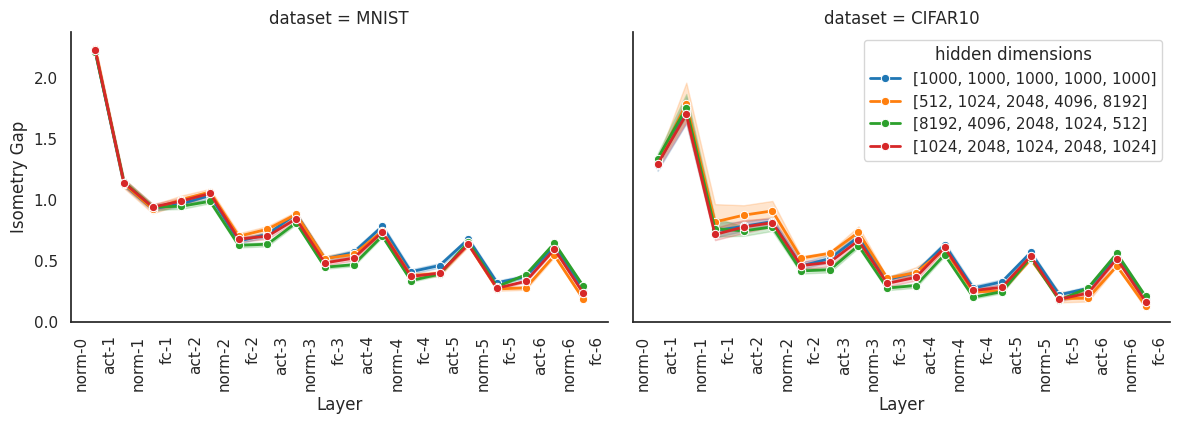

In [2]:
# Define the config grid with lists of possible values for each parameter
config_grid = {
    'model': ['MLP'],
    'dataset': ['MNIST', 'CIFAR10',],
    'hidden_sizes': [
        [1000,]*5, 
        [int(2**(l+9)) for l in range(5)], 
        [2**(13-l) for l in range(5)], 
        [1024*2**(l%2) for l in range(5)]],
    'batch_size': [100],
    'learning_rate': [0.01,],
    'num_epochs': [1],
    'rerun': range(1),
    'reduce_mean': [False],
    'activation': ["ReLU"], #["ReLU", "PReLU", "Tanh", "Identity","SELU","SiLU", "ELU", "GELU"],
    'normalization': ["LN",],
}

final_results_df = run_experiment_grid(config_grid)


df = final_results_df
df = df.loc[df.stage=='train']
g = sns.FacetGrid(df, col="dataset", col_wrap=2, height=4, aspect=1.5, hue='mlp_shape', palette="tab10")#, hue_order=activation_beta_df.activation, palette=palette_dict,)
g.map(sns.lineplot, 'layer', 'iso_gap', linewidth=2, marker='o',)
g.set(xlabel='Layer', ylabel='Isometry Gap')
for ax in g.axes.flat:
    ax.set_xticks(df['l'].unique()-.5)
    ax.set_xticklabels(df['layer'].unique(), rotation=90, )

plt.legend(title='hidden dimensions')
plt.savefig('mlp_shape.pdf', bbox_inches='tight')
plt.show()

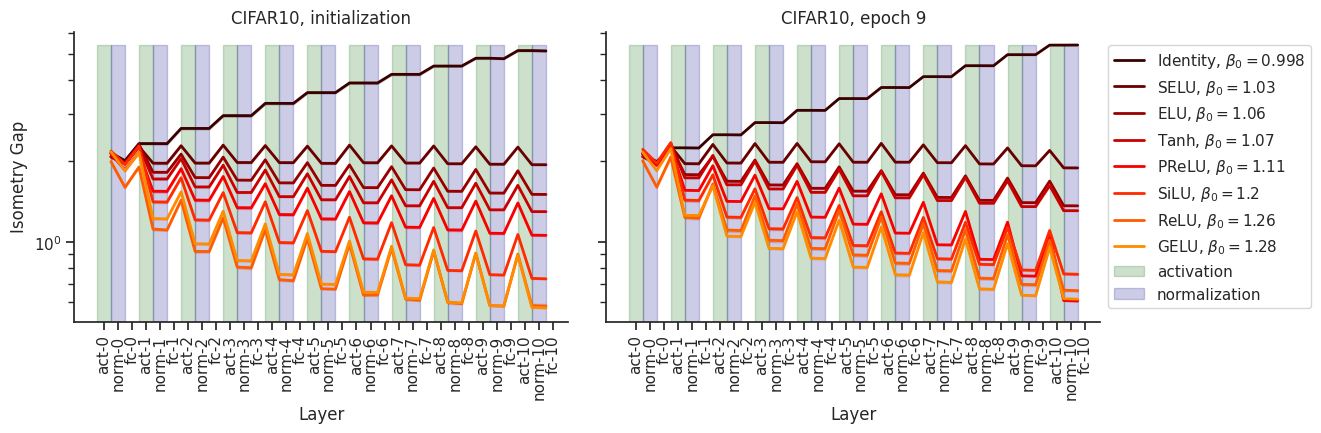

In [30]:
# Define the config grid with lists of possible values for each parameter
config_grid = {
    'model': ['MLP'],
    'dataset': ['CIFAR10',],
    'hidden_sizes': [[1000]*10],
    'batch_size': [100],
    'learning_rate': [0.01,],
    'num_epochs': [10],
    'rerun': range(1),
    'reduce_mean': [False],
    'activation': ["ReLU", "PReLU", "Tanh", "Identity","SELU","SiLU", "ELU", "GELU"],
    'normalization': ["LN",],
}


# final_results_df = run_experiment_grid(config_grid)
final_results_df = pd.read_csv('results_training.csv')


df = final_results_df
df = df.loc[df.stage=='train']
df = df.loc[df.dataset=='CIFAR10']
df = df.loc[df.epoch.isin([0,9])]
df.activation = df.activation.apply(lambda x: x.split(',')[0])
df['activation']  = df.apply(lambda x: f"{x.activation}, $\\beta_0 = {x.beta:.3}$", axis=1)

activation_beta_df = df[['activation', 'beta']].drop_duplicates().sort_values('beta')
colors = sns.color_palette("hot", n_colors=len(activation_beta_df)+5)
palette_dict = {activation: color for activation, color in zip(activation_beta_df['activation'], colors)}
g = sns.FacetGrid(df, col="epoch", col_wrap=2, height=4, aspect=1.4, hue='activation', hue_order=activation_beta_df.activation, palette=palette_dict,)
g.map(sns.lineplot, 'layer', 'iso_gap', linewidth=2).set(yscale = 'log')
# Adding titles and labels
g.set_axis_labels('Layer', 'Isometry Gap')

# Iterate through each facet and set custom xticks
for ax, epoch in zip(g.axes.flat, df.epoch.unique()):
    if epoch==0:
        ax.set_title('CIFAR10, initialization')
    else:
        ax.set_title(f'CIFAR10, epoch {epoch}')
    ax.set_xticks(df['l'].unique()-.5)
    ax.set_xticklabels(df['layer'].unique(), rotation=90, )

    for marker,layer, desc in [('darkgreen','act', 'activation'), ('darkblue','norm', 'normalization')]:#, ('^', 'fc')]:
        df2 = df.loc[df.layer.str.contains(layer)&(df.epoch==epoch)].groupby(['activation', 'l'])['iso_gap'].mean().reset_index()
        for li,l in enumerate(df2.l.unique()):
            if li==0:
                ax.fill_betweenx([0,df.iso_gap.max()], l-1, l, color=marker, alpha=0.2, label=desc)
            else:
                ax.fill_betweenx([0,df.iso_gap.max()], l-1, l, color=marker, alpha=0.2)

ax.legend(loc='center left', bbox_to_anchor=(1,.5))
plt.savefig('iso_gap_int_train.pdf', bbox_inches='tight')
plt.show()

Running experiment for config: {'model': 'MLP', 'dataset': 'CIFAR10', 'hidden_sizes': [5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000], 'batch_size': 100, 'learning_rate': 0.01, 'num_epochs': 1, 'rerun': 0, 'activation': 'Sigmoid', 'reduce_mean': False, 'normalization': 'LN'}
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/1 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 10.12%


100%|██████████| 1/1 [00:02<00:00,  2.95s/it]


Running experiment for config: {'model': 'MLP', 'dataset': 'CIFAR10', 'hidden_sizes': [5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000], 'batch_size': 100, 'learning_rate': 0.01, 'num_epochs': 1, 'rerun': 0, 'activation': 'Tanh', 'reduce_mean': False, 'normalization': 'LN'}
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/1 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 11.83%


100%|██████████| 1/1 [00:02<00:00,  2.97s/it]


Running experiment for config: {'model': 'MLP', 'dataset': 'CIFAR10', 'hidden_sizes': [5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000], 'batch_size': 100, 'learning_rate': 0.01, 'num_epochs': 1, 'rerun': 0, 'activation': 'ReLU', 'reduce_mean': False, 'normalization': 'LN'}
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/1 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 10.41%


100%|██████████| 1/1 [00:02<00:00,  2.95s/it]


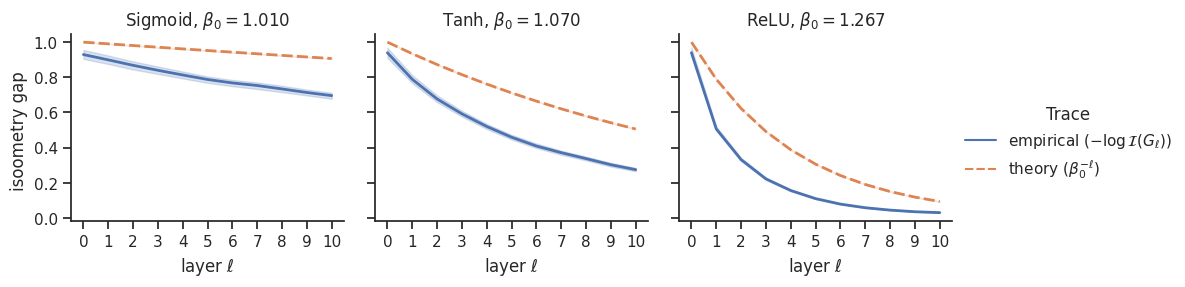

In [204]:
config_grid = {
    'model': ['MLP'],
    'dataset': ['CIFAR10',],
    'hidden_sizes': [[5000]*10],
    'batch_size': [100],
    'learning_rate': [0.01,],
    'num_epochs': [1],
    'rerun': range(1),
    'activation': ["Sigmoid", "Tanh", "ReLU"],
    'reduce_mean': [False],
    'normalization': ["LN",],
}


final_results_df = run_experiment_grid(config_grid)

# Assuming final_results_df is already defined
df = final_results_df.query("stage == 'train' & dataset == 'CIFAR10' & layer.str.contains('norm')").copy()

# Simplifying the creation of 'activation' and 'layer_idx' columns
df['activation'] = df.apply(lambda x: f"{x.activation}, $\\beta_0 = {x.beta:.3f}$", axis=1)
df['layer_idx'] = df['layer'].str.extract('-(\d+)$').astype(int)

# Creating the empirical and theory traces
df['trace'] = 'empirical ($-\\log\\mathcal{I}(G_\\ell)$)'
df_theory = df.copy()
df_theory['trace'] = 'theory ($\\beta_0^{-\\ell}$)'
df_theory['iso_gap'] = df_theory.apply(lambda x: 1.0*x.beta**(-x.layer_idx), axis=1)

# Concatenating the dataframes
df = pd.concat([df, df_theory])

# Plotting
g = sns.FacetGrid(df, col="activation",  height=3, aspect=1.1,)
g.map_dataframe(sns.lineplot, x='layer_idx', y='iso_gap', style='trace',hue='trace', linewidth=2, )

# Setting titles with only activation values and adjusting the legends
g.set_titles(col_template="{col_name}")
g.add_legend(title='Trace')
g.set(xlabel='layer $\\ell$', xticks=df['layer_idx'].unique(), ylabel='isoometry gap ')
plt.savefig('isogap_vs_theory.pdf', bbox_inches='tight')

plt.show()


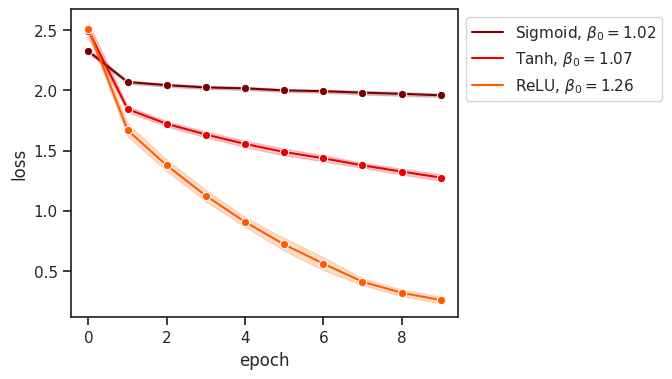

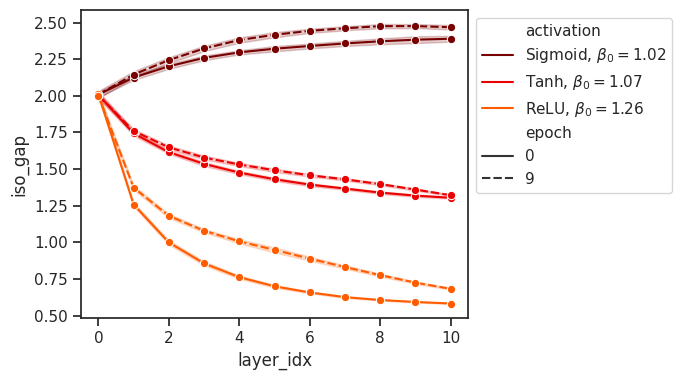

In [262]:

# Define the configuration grid with lists of possible values for each parameter
config_grid = {
    'model': ['MLP'],
    'dataset': ['CIFAR10'],
    'reduce_mean': [False],
    'hidden_sizes': [[1000]*10],
    'batch_size': [512],
    'learning_rate': [0.01],
    'num_epochs': [10],
    'rerun': range(5),
    'activation': ['ReLU', 'Sigmoid', 'Tanh'],  # You can add more activations like "Identity", "PReLU", etc.
    'normalization': ["LN"],
}

# Uncomment the next line to run the experiment grid
# final_results_df = run_experiment_grid(config_grid)
# final_results_df.to_csv('results_training.csv')
# Uncomment the next line to read data from a CSV file
final_results_df = pd.read_csv('results_training.csv')

df = final_results_df.copy()
df = df.query("stage == 'train' & layer.str.contains('norm')").copy()

df['activation'] = df.activation.str.split(',').str[0]
df['layer_idx'] = df['layer'].str.extract('-(\d+)$').astype(int)
df['activation'] = df.apply(lambda x: f"{x.activation}, $\\beta_0 = {x.beta:.3}$", axis=1)

# Creating a palette based on activation and beta values
activation_beta_df = df[['activation', 'beta']].drop_duplicates().sort_values('beta')
colors = sns.color_palette("hot", n_colors=len(activation_beta_df)+2)
palette_dict = dict(zip(activation_beta_df['activation'], colors))

# Plotting
plt.figure(figsize=(5, 4))
ax = sns.lineplot(data=df, x='epoch', y='loss', hue='activation',errorbar="sd",
                  hue_order=activation_beta_df.activation, palette=palette_dict, marker='o')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.savefig('beta0_train_loss.pdf', bbox_inches='tight')
plt.show()

plt.figure(figsize=(5, 4))
ax = sns.lineplot(df.loc[df.epoch.isin([0,9])],  x='layer_idx', y='iso_gap', hue='activation', style='epoch',errorbar='sd',
            hue_order=activation_beta_df.activation, palette=palette_dict, marker='o')
ax.legend(loc= "upper left", bbox_to_anchor=(1, 1))
plt.savefig('iso_gap_train.pdf', bbox_inches='tight')
plt.show()